# Analysis of the autism data


The objective of this notebook is to identify the CVA variable whom the missignness may be associated with the diagnosis. 
The hypothesis underlying the treatment of missing variables among the predictors is important as it can biased the estimated models and their prediction. 
One want to know whether the CVA variables should rather be hypothesized as Missing Completely at Random (MNAR; in which case it is not necessary to model their missignness as it could add noise to the model, we might event prevent the model to use such missingness as predictors (for post-hoc model interpretability analysis, we must control that the significant predictors of the diagnosis are not the missingness of MCAR variable), Missing at Random (MAR; in which case we also do not want to add the information thta it is missing explicitely, but rather model it implicitely by design of the algorithm (if one feature is missing, it might not directly  associated with the final diagnosis, but could condition the way other prdictors are handled by the model). Finally, the Missing Not at Random hypothesis (MNAR; one may want to explicitely model such missingness to add to the set of predictors).

Method.

1) We go over each of the missing block variables (features always missing together e.g. the touch features). 
2) We run a statstical test to control whether the diagnosis is a statistically significant contributor of having a feature missing. This could be done using an ANOVA. 
3) The features for who the diagnosis is a significant predictor will be accounted for in the model, either adding an indicator variable, or by modeling the missignness in the feature space. 



In [1]:
run init.ipynb 

Done.


In [4]:
grouped_missing_features = {'Floating Bubbles': ['FB_postural_sway', 'FB_postural_sway_derivative'],
                             'DogInGrassC': ['DIGC_postural_sway', 'DIGC_postural_sway_derivative'],
                             'DogInGrassRRL': ['DIGRRL_postural_sway', 'DIGRRL_postural_sway_derivative'],
                             'SpinningTop': ['ST_postural_sway', 'ST_postural_sway_derivative'],
                            
                             'PlayingWithBlocks': ['PWB_postural_sway', 'PWB_postural_sway_derivative'],
                             'FunAtThePark': ['FP_postural_sway', 'FP_postural_sway_derivative', 
                                              'FP_gaze_speech_correlation', 'FP_gaze_silhouette_score'], 

                            'MechanicalPuppy': ['MP_postural_sway', 'MP_postural_sway_derivative'],
                             'BlowingBubbles': ['BB_gaze_percent_right', 'BB_gaze_percent_right',
                                                'BB_postural_sway', 'BB_postural_sway_derivative'],
                            
                             'Social gaze': ['S_gaze_percent_right', 'S_gaze_silhouette_score'],
                             'Silhouette Score': ['gaze_silhouette_score'],    
                             'Gaze percent Right': ['mean_gaze_percent_right'], 
                            
                            'S PosturalSway':['S_postural_sway'], 
                            'NS PosturalSway':['NS_postural_sway'], 
                            
                            'S PosturalSwayDerivative':['S_postural_sway_derivative'], 
                            'NS PosturalSwayDerivative':['NS_postural_sway_derivative'],                             
                            
                             'RhymesAndToys': ['RT_postural_sway', 'RT_postural_sway_derivative'],
                             'MakeMeLaugh': ['MML_postural_sway', 'MML_postural_sway_derivative'],
                            
                             'RTN': ['proportion_of_name_call_responses'],
                             'RTNB': ['name_call_response_binary'],
                             'RTNDelay': ['average_response_to_name_delay'],
                            
                             'Game administration': ['number_of_touches', 'number_of_target', 'exploratory_percentage'],
                             'NoTouches': ['average_length',
                                                  'std_length',
                                                  'pop_rate',
                                                  'average_touch_duration',
                                                  'std_touch_duration',
                                                  'average_accuracy_variation',
                                                  'accuracy_consistency'],
                             'TimeSpent': ['average_time_spent', 'std_time_spent']}

def select(df, feat, value):
    return df[df[feat]==value]

df = pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='without', 
               imputation_method='without', 
               sampling_method='without',
               outcome_column='diagnosis',
                features_name = deepcopy(DEFAULT_PREDICTORS), 
                scale_data=False,
                use_missing_indicator_variables=grouped_missing_features, #use_missing_indicator_variables,#grouped_missing_features,
               verbosity=0,
               scenario='multimodal_2023',#'papers',
               proportion_train=1)

467 administrations left.


,id
diagnosis,
0.0,417
1.0,50


In [5]:
from scipy.stats import chi2_contingency
list_features_mnar = {}

results_df = pd.DataFrame(columns = ['diagnosis', 'features', 'missing_proportion', 'p_values'])
for name, feature_missing in grouped_missing_features.items():
    
    # Make sure than when the block variable are missing all are missing at the same time or not at all
    if not  (~(data.df[feature_missing].isna().sum(axis=1)).isin([0, len(feature_missing)])).sum() == 0:
        print(name, (~(data.df[feature_missing].isna().sum(axis=1)).isin([0, len(feature_missing)])).sum())


    table = pd.crosstab(data.df['Z_{}'.format(name)], data.df['diagnosis']).to_numpy()
    

    stat, p, dof, expected = chi2_contingency(np.array(table))

    n_values_with = len(data.df[data.df['Z_{}'.format(name)]==0])
    n_values_without = len(data.df[data.df['Z_{}'.format(name)]==1])

    if n_values_with < 20 or n_values_without < 20:
        continue

    #print("Features missing")
    #print("\n".join(feature_missing))
    #display(pd.crosstab(data.df['Z_{}'.format(name)], data.df['diagnosis']))
    #print(f"P value: {p}")
    #print('\n\n\n')
    
    if p < 0.05:
        list_features_mnar[name] = feature_missing
        
    results_df = results_df.append(pd.DataFrame({'diagnosis':[0, 1], 
                                    'features': [name, name], 
                                    'missing_proportion': (table/table.sum(axis=0))[1],
                                    'p_values': [p,p]
                                    }))


FunAtThePark 3
BlowingBubbles 3


(0.0, 1.0)

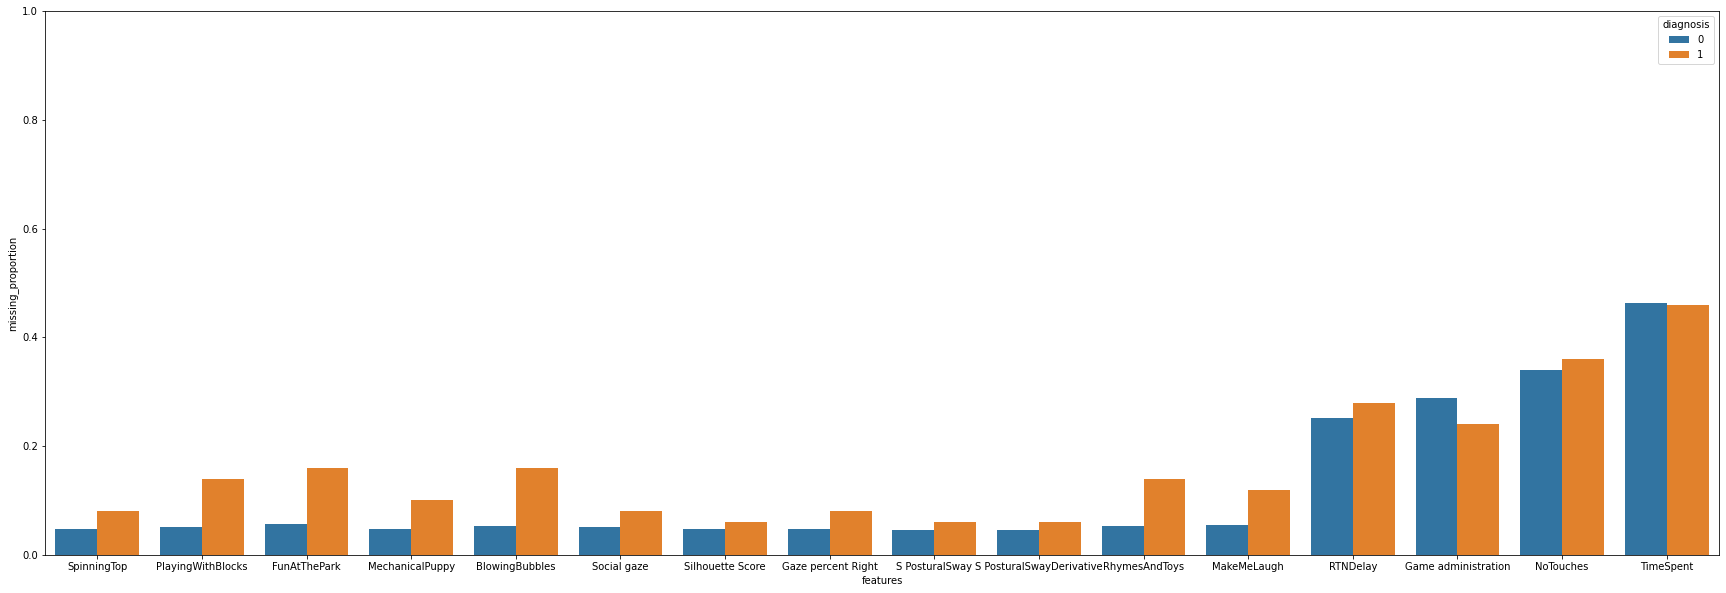

In [6]:
fi(30, 10)
sns.barplot(data=results_df, x="features", y="missing_proportion", hue="diagnosis")
plt.ylim([0,1])

In [7]:
results_df[(results_df['diagnosis']==1) & (results_df['p_values'] <= 0.05)]

,diagnosis,features,missing_proportion,p_values
1,1,PlayingWithBlocks,0.14,0.027264
1,1,FunAtThePark,0.16,0.015809
1,1,BlowingBubbles,0.16,0.008859
1,1,RhymesAndToys,0.14,0.035256
